In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from scipy.stats import norm, linregress
import matplotlib.pyplot as plt
import sys
import time
import pdb
from itertools import chain, product
import itertools
import string

from scipy.sparse import csr_matrix

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [397]:

def mean_value_bp(values, alphabet_size, strategy="uniform"):
    if strategy == "uniform":
        values_min = np.min(values)
        values_max = np.max(values)
        return np.linspace(values_min, values_max, alphabet_size+1)[1:-1]
    elif strategy == "normal":
        return norm.ppf(np.linspace(0, 1, alphabet_size+1)[1:-1], np.mean(values), np.std(values))

    
def slope_bp(alphabet_size):
    values_min = -np.pi/4
    values_max = np.pi/4
    return np.linspace(values_min, values_max, alphabet_size+1)[1:-1]


class DocumentTimeSeries(object):
    def __init__(self, alph_size=4, word_length=2, window=100, alphabet=["a", "b", "c", "d"], 
                 feature="mean", bp_strategy="uniform", tol=2, global_break_points=False, threshold=2):
        self.word_length=word_length
        self.alph_size=alph_size
        self.window=window
        self.feature = feature
        self.bp_strategy=bp_strategy
        self.tol = tol
        self.global_break_points = global_break_points
        self.threshold = threshold
        self.bp = None
        self.ini_time = 0
        self.end_time = window
        self.alphabet = alphabet
    
    def get_break_points(self, ts_data):
        if self.feature == "mean":
            return mean_value_bp(ts_data, self.alph_size, strategy=self.bp_strategy)
        elif self.feature == "trend":
            return slope_bp(self.alph_size)
        
    def gen_document(self, ts_data, ts_times, strategy="all_sub_sequence", **kwargs):
        if strategy == "all_sub_sequence":
            return " ".join(self.transform_all_sub_sequence(ts_data, ts_times))
        else:
            raise ValueError("not implemented")
        
    def transform_all_sub_sequence(self, ts_data, ts_time):
        doc = []
        i = 0
        j = 1
        n = ts_data.size
        ini_obs, end_obs = ts_time[0], ts_time[n-1]
        if self.global_break_points:
            self.bp = self.get_break_points(ts_data)
        while i < n - self.tol:
            self.ini_time, self.end_time = ts_time[i], ts_time[i] + self.window
            while ts_time[j]  < self.end_time:
                if j == n-1:
                    break
                j += 1
#             if self.window == 100:
#                 print(self.ini_time, self.end_time, i, j)
            if j - i > self.tol:
                if not self.global_break_points:
                    self.bp = self.get_break_points(ts_data[i:j])
#                 if self.window == 100:
#                     print(i, j, self.bp)
                word = self.sequence_to_word(ts_data, ts_time, i, j)
                if word.count("#") <= self.threshold:
                    doc.append(word)
            i += 1
        return doc
    
    def sequence_to_word(self, ts_data, ts_time, i, j):
        if self.word_length > 1:
            seg_limits = np.linspace(self.ini_time, self.end_time, self.word_length + 1)[1:]
            
#             if self.window == 100:
#                 print(seg_limits)
            word = ''
            ii = i
            jj = i+1
            for k in range(self.word_length):
                while ts_time[jj] < seg_limits[k]:
                    if jj == j:
                        break
                    jj += 1
#                 if self.window == 100:
#                     print(k, ii, jj)
                if jj - ii > self.tol:
                    val = self.segment_to_char(ts_data, ts_time, ii, jj)
                else:
                    val = "#"
                word += val
                ii = jj
            return word
        else:
            return self.segment_to_char(ts_data, ts_time, i, j)
        
    def segment_to_char(self, ts_data, ts_time, i, j):
        if self.feature == "mean":
            mean = np.mean(ts_data[i:j])
#             if self.window == 100:
#                 print(mean)
            return self.alphabet[np.digitize(mean, self.bp)]
        elif self.feature == "trend":
            slope, _,_,_,_ = linregress(ts_time[i:j], ts_data[i:j])
            trend = np.arctan(slope)
            return self.alphabet[np.digitize(trend, self.bp)]

In [398]:
def load_numpy_dataset(data_path, file_base):
    dataset = np.load(os.path.join(data_path, file_base % "d"), allow_pickle=True)
    for i in range(dataset.size):
        dataset[i] = preprocessing.scale(dataset[i])
    times = np.load(os.path.join(data_path, file_base % "t"), allow_pickle=True)
    labels = np.load(os.path.join(data_path, file_base % "l"), allow_pickle=True)
    return dataset, times, labels.astype(int), len(dataset)

def predict_class_cosine(similarity_matrix, train_label, n_train, n_test):
    pred_labels = []
    for j in range(n_test):
        dmax = -np.inf
        label = -1
        for i in range(n_train):
            if similarity_matrix[i][j] > dmax:
                dmax = similarity_matrix[i][j]
                label = train_label[i]
        pred_labels.append(label)
    return pred_labels

def predict_class_euclidean(similairty_matrix, train_label, n_train, n_test):
    pred_labels = []
    for j in range(n_test):
        dmin = np.inf
        label = -1
        for i in range(n_train):
            if similairty_matrix[i][j] < dmin:
                dmin = similairty_matrix[i][j]
                label = train_label[i]
        pred_labels.append(label)
    return pred_labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()

In [498]:
%%time
main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..'))
data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "3_min")
key = "wdf"
train_base = key + "_train_%s.npy"
test_base = key + "_test_%s.npy"
d_train, t_train, l_train, n_train = load_numpy_dataset(data_path, train_base)
d_test, t_test, l_test, n_test = load_numpy_dataset(data_path, test_base)

CPU times: user 246 ms, sys: 2.99 ms, total: 249 ms
Wall time: 247 ms


1040.167100000006


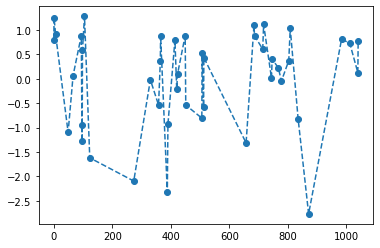

In [499]:
i =0
i = 104
plt.plot(t_test[i] - t_test[i][0], d_test[i], 'o--')
print(t_test[i][-1] - t_test[i][0])

In [500]:
def multi_window_document(ts_data, ts_time, windows, j,
                          alph_size=4, word_length=2, 
                          feature="mean", threshold=1, bp_strategy="uniform", 
                          tol=2, global_break_points=False):
    full_alphabet = list(string.ascii_lowercase)
    full_alphabet.extend(list(string.ascii_uppercase))
    i = 0
    full_doc = ""
    for w in windows:
#         print(w)
        alphabet = full_alphabet[i:i+alph_size]
#         print(alphabet)
        doc_ts = DocumentTimeSeries(alph_size=alph_size, word_length=word_length, 
                                    window=w, alphabet=alphabet, feature=feature, 
                                    bp_strategy=bp_strategy, tol=tol, 
                                    global_break_points=global_break_points, 
                                    threshold=threshold)
#         print(doc_ts.dictionary)
        doc = doc_ts.gen_document(ts_data, ts_time)
        i += alph_size
        if len(full_doc) > 0:
            full_doc += " "
        full_doc += doc
    if len(full_doc) == 0:
        print("fail", j)
    return full_doc

def document_numerosity_reduction(doc):
    doc_arr = doc.split()
    new_doc = [doc_arr[0]]
    pword = doc_arr[0]
    for i in range(1,len(doc_arr)):
        if pword != doc_arr[i]:
            new_doc.append(doc_arr[i])
            pword = doc_arr[i]
    return " ".join(new_doc)

def multi_word_document(ts_data, ts_time, word_lengths, 
                        alph_size=4, window=100, feature="mean", thresholds=None, 
                        bp_strategy="uniform", tol=2, global_break_points=False):
    if thresholds is None:
        thresholds = [0] * len(word_lengths)
    full_alphabet = list(string.ascii_lowercase)
    full_alphabet.extend(list(string.ascii_uppercase))
    alphabet = full_alphabet[:alph_size]
    full_doc = ""
    i=0
#     print("thresholds:", thresholds)
#     print("word lengths:", word_lengths)
    assert len(thresholds) == len(word_lengths)
    for word_length, thr in zip(word_lengths, thresholds):
#         print(word_length)
        doc_ts = DocumentTimeSeries(alph_size=alph_size, word_length=word_length, 
                                    window=window, alphabet=alphabet, feature=feature, 
                                    bp_strategy=bp_strategy, tol=tol, 
                                    global_break_points=global_break_points, 
                                    threshold=thr)
        doc = doc_ts.gen_document(ts_data, ts_time)
        if len(full_doc) > 0:
            full_doc += " "
        full_doc += doc
    if len(full_doc) == 0:
        print("fail")
    return full_doc

'bd bd bd bd bc bc bc bc cb db db db db db cb cb cc cc ll lm lm ml ml kl ll lk li li li mi mj mj nj nj oj pj pj pj mj kj ru qu qw qw qw rw rw tv tv yE AD zD DC CC'


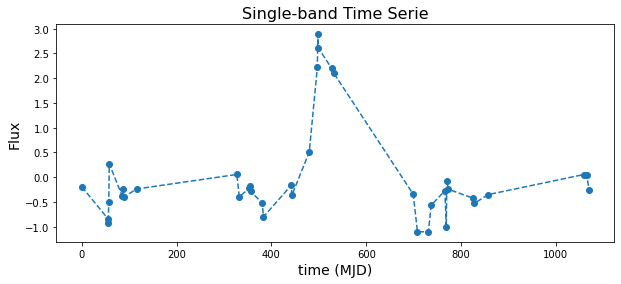

In [501]:
# %%time
alph_size=8
word_length = 2
windows = [800, 400, 200, 100]
feature = "mean"
threshold = 0
i = 204
plt.figure(figsize=(10, 4))
plt.plot(t_train[i] - t_train[i][0], d_train[i], 'o--')
plt.xlabel("time (MJD)", fontsize=14)
plt.ylabel("Flux", fontsize=14)
plt.title("Single-band Time Serie", fontsize=16)

doc0 = multi_window_document(d_train[i], t_train[i], windows, j,
                          alph_size=alph_size, word_length=word_length, 
                          feature=feature, threshold=threshold, bp_strategy="uniform", 
                          tol=2, global_break_points=False)
# vocabulary
new_doc0 = document_numerosity_reduction(doc0)
print("'%s'" % doc0)
# print(new_doc0)

In [606]:
alph_size=8
word_length = 2
# windows = [800, 400, 200, 100]
windows = [800, 400, 200]
feature = "mean"
threshold = 0
# tol = 3
tol = 1
n_components = 20
k = len(windows) * alph_size
full_alphabet = list(string.ascii_lowercase)
full_alphabet.extend(list(string.ascii_uppercase))
vocabulary = []
for k in range(len(windows)):
    used_alphabet = full_alphabet[k*alph_size:(k+1)*alph_size]
    if threshold > 0:
        used_alphabet.append('#')
    vocabulary.extend(list(map(''.join,
                              chain.from_iterable(product(used_alphabet,
                                                         repeat=word_length) for i in range(1)))))
vocabulary = np.unique(vocabulary)
print(full_alphabet[:(k+1)*alph_size])
# vocabulary = np.unique(vocabulary)
if word_length == 1:
    print(vocabulary)
else:
    print("len vocabulary: ", len(vocabulary))
# print(vocabulary)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']
len vocabulary:  192


In [607]:
%%time
corpus = []
for j in range(n_train):
#     print(j, end="\r")
    doc = multi_window_document(d_train[j], t_train[j], windows, j,
                          alph_size=alph_size, word_length=word_length, 
                          feature=feature, threshold=threshold, bp_strategy="uniform", 
                          tol=tol, global_break_points=False)
#     doc = document_numerosity_reduction(doc)
    corpus.append(doc)

CPU times: user 4.4 s, sys: 133 ms, total: 4.54 s
Wall time: 4.39 s


In [608]:
%%time
corpus2 = []
for j in range(n_test):
#     print(j, end="\r")
    doc = multi_window_document(d_test[j], t_test[j], windows, j, 
                          alph_size=alph_size, word_length=word_length, 
                          feature=feature, threshold=threshold, bp_strategy="uniform", 
                          tol=tol, global_break_points=False)
#     doc = document_numerosity_reduction(doc)
    corpus2.append(doc)

CPU times: user 3.03 s, sys: 107 ms, total: 3.14 s
Wall time: 2.96 s


In [609]:
analyzer = "word" if word_length > 1 else "char"
vect = CountVectorizer(lowercase=False, vocabulary=vocabulary, analyzer=analyzer)

In [610]:
%%time
X = vect.fit_transform(corpus)
X2 = vect.transform(corpus2)

CPU times: user 21.5 ms, sys: 503 µs, total: 22 ms
Wall time: 21.4 ms


In [611]:
%%time
transf = TfidfTransformer()
tf_idf = transf.fit_transform(X)
tf_idf2 = transf.fit_transform(X2)
tf_idf.shape

CPU times: user 2.19 ms, sys: 1.05 ms, total: 3.23 ms
Wall time: 2.51 ms


(461, 192)

In [612]:
# tf_idf = tf_idf.todense()
# tf_idf2 = tf_idf2.todense()

In [613]:
# discard this normalization
# std_scaler = StandardScaler(with_mean=False)
# tf_idf_scaled = std_scaler.fit_transform(tf_idf)
# tf_idf2_scaled = std_scaler.transform(tf_idf2)

# we dont normalize since tf-idf is a normalization
n_com = min(n_components-0, n_train, n_test, tf_idf.shape[1]-1)
pca = TruncatedSVD(n_components=n_com, n_iter=20)
# pca = PCA(n_components=n_com)
tf_idf_pca = pca.fit_transform(tf_idf)
tf_idf2_pca = pca.transform(tf_idf2)
print(tf_idf_pca.shape)

(461, 20)


0.6022128007692247
Confusion matrix, without normalization


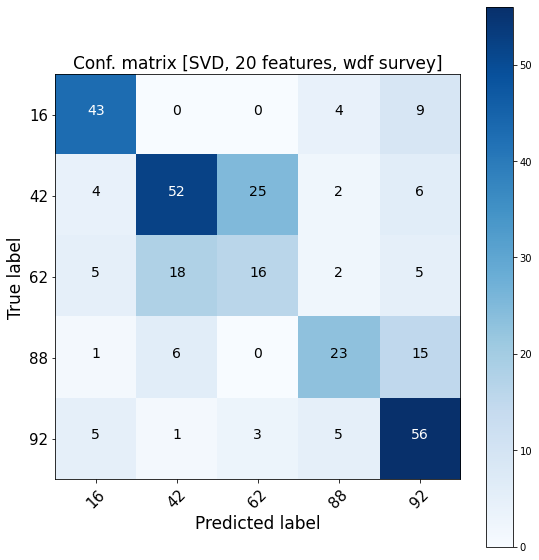

In [614]:
cos_sim = cosine_similarity(tf_idf_pca, tf_idf2_pca)
cos_pred = predict_class_cosine(cos_sim, l_train, n_train, n_test)
cos_acc = balanced_accuracy_score(l_test, cos_pred)
conf = confusion_matrix(l_test, cos_pred)
print(cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(l_train), normalize=False, 
                     title= "Conf. matrix [SVD, %d features, %s survey]" % (n_com, key))

In [619]:
1-0.543

0.45699999999999996

0.5431235412256419
Confusion matrix, without normalization


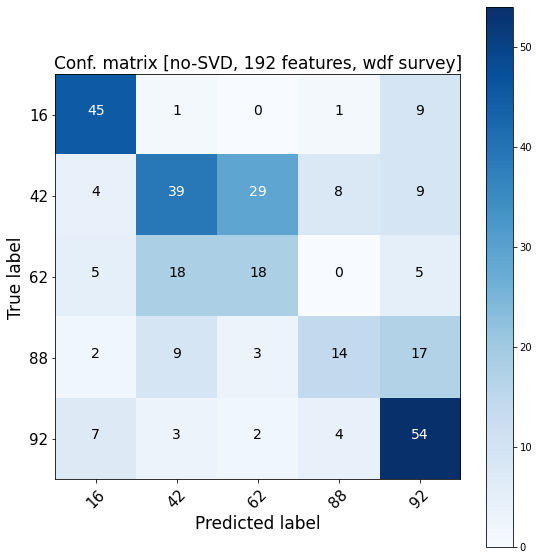

In [617]:
cos_sim = cosine_similarity(tf_idf, tf_idf2)
cos_pred = predict_class_cosine(cos_sim, l_train, n_train, n_test)
cos_acc = balanced_accuracy_score(l_test, cos_pred)
conf = confusion_matrix(l_test, cos_pred)
print(cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(l_train), normalize=False, 
                     title= "Conf. matrix [no-SVD, %d features, %s survey]" % (tf_idf.shape[1], key))

### multi-word document representation

In [90]:
# %%time
alph_size=8
word_lengths = [1, 2, 4]
window = 400
feature = "mean"
thresholds = [0, 0, 1]
i = 20
doc0 = multi_word_document(d_train[i], t_train[i], word_lengths, 
                          alph_size=alph_size, window=window, 
                          feature=feature, thresholds=thresholds, bp_strategy="uniform", 
                          tol=2, global_break_points=False)
# vocabulary
new_doc0 = document_numerosity_reduction(doc0)
print(doc0)
print(new_doc0)

f e e e e d d d d d d d d d d e e e e e e e d d d c c d e e d e e e e e e e e f e e gb gb gb gc hc fc fc fd ed ed fd fd de df df de de de ee ee ed ed fc fc fc e#ad e#ad f#ae f#ae cg#e f#ac f#bc
f e d e d c d e d e f e gb gc hc fc fd ed fd de df de ee ed fc e#ad f#ae cg#e f#ac f#bc


In [290]:
alph_size=8
word_lengths = [1, 2, 3]
window = 400
feature = "mean"
thresholds = [1, 2, 3]
tol = 3
n_components = 20
k = len(word_lengths) * alph_size
full_alphabet = list(string.ascii_lowercase)
full_alphabet.extend(list(string.ascii_uppercase))
used_alphabet = full_alphabet[:k]
if max(thresholds) > 0:
    used_alphabet.append('#')
print(used_alphabet)
vocabulary = list(map(''.join, 
         chain.from_iterable(product(used_alphabet, 
                                     repeat=i) for i in [1, 2, 4])))
# vocabulary = np.unique(vocabulary)
if max(word_lengths) == 1:
    print(vocabulary)
else:
    print("len vocabulary: ", len(vocabulary))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', '#']
len vocabulary:  391275


In [291]:
%%time
corpus3 = []
for j in range(n_train):
#     print(j, end="\r")
    doc = multi_word_document(d_train[j], t_train[j], word_lengths, 
                          alph_size=alph_size, window=window, 
                          feature=feature, thresholds=thresholds, bp_strategy="uniform", 
                          tol=tol, global_break_points=False)
#     doc = document_numerosity_reduction(doc)
    corpus3.append(doc)

CPU times: user 3.71 s, sys: 182 ms, total: 3.89 s
Wall time: 3.66 s


In [292]:
%%time
corpus4 = []
for j in range(n_test):
#     print(j, end="\r")
    doc = multi_word_document(d_test[j], t_test[j], word_lengths, 
                          alph_size=alph_size, window=window, 
                          feature=feature, thresholds=thresholds, bp_strategy="uniform", 
                          tol=tol, global_break_points=False)
#     doc = document_numerosity_reduction(doc)
    corpus4.append(doc)

CPU times: user 2.36 s, sys: 62 ms, total: 2.42 s
Wall time: 2.33 s


In [293]:
%%time
analyzer = "word"

vect = CountVectorizer(lowercase=False, vocabulary=vocabulary, analyzer=analyzer, tokenizer=lambda txt: txt.split())


X3 = vect.fit_transform(corpus3)
X4 = vect.transform(corpus4)

transf = TfidfTransformer()
tf_idf3 = transf.fit_transform(X3)
tf_idf4 = transf.fit_transform(X4)

n_com = min(n_components, n_train, n_test, tf_idf3.shape[1]-1)
pca = TruncatedSVD(n_components=n_com, n_iter=20)
tf_idf3_pca = pca.fit_transform(tf_idf3)
tf_idf4_pca = pca.transform(tf_idf4)

CPU times: user 22.4 s, sys: 21.8 s, total: 44.2 s
Wall time: 6.78 s


0.5091999519234498
Confusion matrix, without normalization


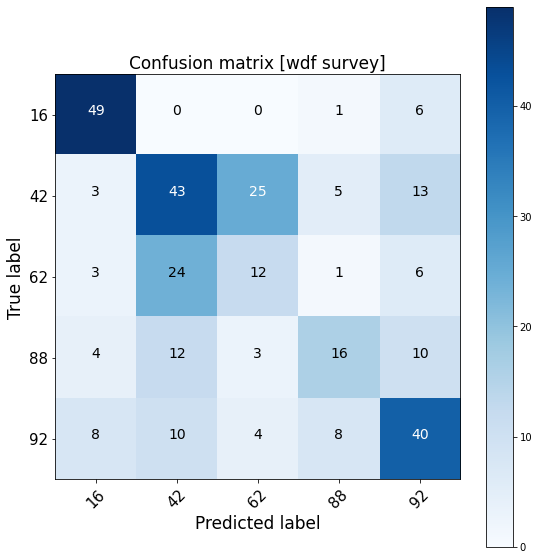

In [294]:
cos_sim = cosine_similarity(tf_idf3_pca, tf_idf4_pca)
cos_pred = predict_class_cosine(cos_sim, l_train, n_train, n_test)
cos_acc = balanced_accuracy_score(l_test, cos_pred)
conf = confusion_matrix(l_test, cos_pred)
print(cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(l_train), normalize=False, 
                     title= "Confusion matrix [%s survey]" % key)

0.4556713269903304
Confusion matrix, without normalization


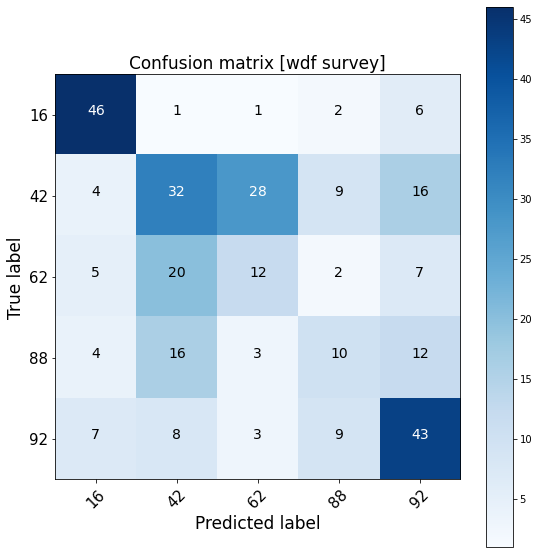

In [295]:
cos_sim = cosine_similarity(tf_idf3, tf_idf4)
cos_pred = predict_class_cosine(cos_sim, l_train, n_train, n_test)
cos_acc = balanced_accuracy_score(l_test, cos_pred)
conf = confusion_matrix(l_test, cos_pred)
print(cos_acc)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf, classes=np.unique(l_train), normalize=False, 
                     title= "Confusion matrix [%s survey]" % key)